# Amazon Fine Food Reviews Analysis with KNN


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive or negative.
We will determine whether a review is positive or negative based on ratings.If score is 1 or 2 then review is negative and if the score is 4 or 5 then review is positive.

Bellow metioned are the steps that we are going to follow:-
 - Data pre-processing step : In this phase we will be performing the following operations:
     - Removal of Stop words.
     - Removal of punctuations marks.
     - Removal of HTML tags.
     - Snow ball stemming of words.
     - Conversion of text into lower case.
     - Using time based splitting, create train and test dataset.
     

 - Create function to find optimal k.
 - Use vectorization methods to convert text into vectors.Bellow mentioned are the methods that we will use:
     - BagOfWords(BOW)
     - Word2Vec
     - tfidf
     - avg. Word2Vec
     - tfidf Word2Vec
     
     
 - On each vectorization method we will be finding optimal K and perform KNN. 
 - Score Prediction
 - Confusion Matrix
     
     
     





In [3]:
# imported necessary libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
#from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

C:\Users\chavha1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect("H:\AppliedAI\Assignment\knn and k-fold cross validation\Amazon Fine Food reviews.sqlite")
#con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
    

In [4]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis
Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [7]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep ='first', inplace=False)
final.shape


(364173, 10)

In [8]:

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100


69.25890143662969

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]





In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts() 



(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [12]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [13]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'yourself', 'did', 'should', "she's", 'as', 'was', 'have', 'a', 'mightn', 'if', 'shan', 'myself', 'isn', 'my', 'out', "mustn't", 'shouldn', 'very', 'aren', 'does', 'o', 'through', 'me', 'couldn', 'than', 'no', 'and', 'from', 'when', 'an', 'of', 'up', 'we', 'y', 'being', 'only', 'doesn', 'haven', 'll', 'just', 'that', 'how', "it's", "you've", 'hers', 'will', 'the', "should've", 've', 'theirs', 'these', 'all', 'ourselves', 'then', 'didn', 'own', 'doing', 'him', 'too', 'on', "doesn't", 'its', 'in', 're', 'below', 'ours', 'off', 'can', 'there', "you'd", 'had', 'whom', "mightn't", "wouldn't", 'other', 'after', 'few', 'who', "that'll", 'which', 'they', 'for', 'is', 'his', 'further', "hasn't", 'before', 'more', 't', 'needn', 'wasn', 'herself', 'ain', 'yours', 'under', 'again', 'both', 'about', 'themselves', 'why', 'some', 'wouldn', "isn't", 'don', 'at', "needn't", 'hasn', "don't", 'you', 'our', 'do', 'but', 'i', 'weren', 'd', 'above', 'm', 'hadn', 'their', "you're", 's', "aren't", 'against',

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 


In [16]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)



In [1]:
import sqlite3
con = sqlite3.connect("final.sqlite")


In [4]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)


In [5]:
cleaned_data.shape

(364171, 12)

In [6]:
# To randomly sample 10k points from both class

data_pos = cleaned_data[cleaned_data["Score"] == "positive"].sample(n = 10000)
data_neg = cleaned_data[cleaned_data["Score"] == "negative"].sample(n = 10000)
final_20k = pd.concat([data_pos, data_neg])
final_20k.shape

(20000, 12)

In [7]:
# Sorting data based on time
final_20k["Time"] = pd.to_datetime(final_20k["Time"], unit = "s")
final_20k = final_20k.sort_values(by = "Time")

# Bag of Word

In [18]:
# Fuction to compute k value
def k_classifier_brute(X_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [8]:
# 40k data which will use to train model after vectorization
X = final_20k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (20000,)


In [9]:
# class label
y = final_20k["Score"]
print("shape of y:", y.shape)

shape of y: (20000,)


In [12]:
# split data into train and test where 70% data used to train model and 30% for test
# final_4000[:int(len(final_4000) * 0.75)], final_4000[int(len(final_4000) * 0.75):]
from sklearn.model_selection import train_test_split


X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape, x_test.shape)

(8978,) (8978,) (6600,)


In [13]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<8978x12665 sparse matrix of type '<class 'numpy.int64'>'
	with 289961 stored elements in Compressed Sparse Row format>

In [14]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [16]:
x_test.shape

(6600, 12665)


The optimal number of neighbors is 23.


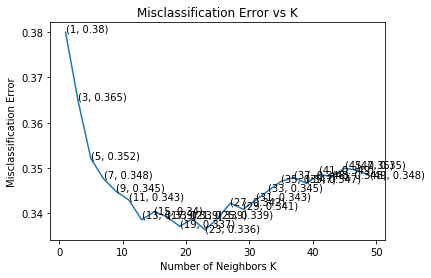

the misclassification error for each k value is :  [0.38  0.365 0.352 0.348 0.345 0.343 0.339 0.34  0.339 0.337 0.339 0.336
 0.339 0.342 0.341 0.343 0.345 0.347 0.348 0.347 0.349 0.348 0.35  0.35
 0.348]


23

In [19]:
# To choose optimal_k using brute force algorithm

optimal_k_bow = k_classifier_brute(X_train, y_train)
optimal_k_bow

In [20]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [21]:
# Accuracy on train data
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.6970372020494542


In [22]:
# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.302963%


In [23]:
# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow, acc_bow))


The accuracy of the knn classifier for k = 23 is 66.000000%


In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1475, 1798],
       [ 446, 2881]], dtype=int64)

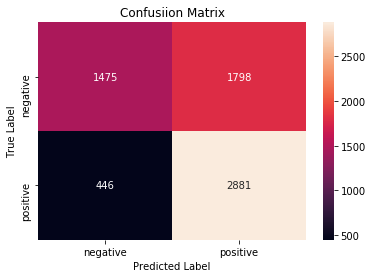

In [25]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.77      0.45      0.57      3273
   positive       0.62      0.87      0.72      3327

avg / total       0.69      0.66      0.64      6600



## Terminology

true positives (TP): We predicted +ve review, and review is also +ve.
true negatives (TN): We predicted -ve, and review is also -ve.
false positives (FP): We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.")
false negatives (FN): We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")

### confusion matrix described
In above confusion matrix(used to describe performence of classifier)

tn(true negative) = 1278, tp(true positive) = 2700, fn(false negative) = 349, fp(false positive) = 1673
And as it is shows in classification report overall accuracy(i.e. how often is the classifier correct?) = (tp+tn)/total = (2700+1278)/6000 = ~66%
And Overall error rate/misclassification rate or 1-accuracy(i.e. how often it is wrong?) --> (fn+fp)/total = (349+1673)/6000 = ~34%
precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 2700/4373 = ~62%
True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 2700/3049 = ~89%
Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 1278/2951 = ~43%. The best specificity is 1.0, whereas the worst is 0.0 .
False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1673/2951 = ~57%
F1 score/F-score/F-measure is weighted avg of precision and recall(tpr).
support is number of elements in each class(+ve and -ve).

### **Observations**

From above figure(misclassification error vs optimal k) It is showing that classification error for each value of k, when k is increaseing the error is decreasing. For ex - if k = 1 then error = 38%, k = 2 error = 37% and so on.
As I tested our model on unseen data(test data) the accuracy is 66% when k = 47.
In confusion matrix, It is clear that out of 6k unseen data-points classifier predict 4373 +ve and 1627 -ve class label but in real 3049 were +ve and 2951 were -ve.
In a nutshell we can say the generalization error is quite high means this model does not work well with unseen data.

# Tf-Idf

In [37]:
# data
X = final_20k["CleanedText"]

In [38]:
# Target/class-label
y = final_20k["Score"]

In [27]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape, x_test.shape)

(8978,) (8978,) (6600,)


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<8978x223500 sparse matrix of type '<class 'numpy.float64'>'
	with 623527 stored elements in Compressed Sparse Row format>

In [29]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(6600, 223500)


The optimal number of neighbors is 49.


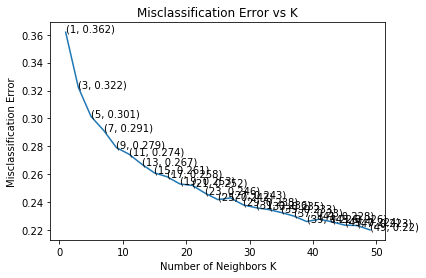

the misclassification error for each k value is :  [0.362 0.322 0.301 0.291 0.279 0.274 0.267 0.261 0.258 0.253 0.252 0.246
 0.242 0.243 0.238 0.236 0.235 0.233 0.23  0.226 0.228 0.226 0.224 0.223
 0.22 ]


49

In [30]:
# To choosing optimal_k
optimal_k_tfidf = k_classifier_brute(X_train, y_train)
optimal_k_tfidf

In [31]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [32]:
# Accuracy on train data
train_acc_tfidf = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 0.802294497660949


In [33]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.197706%


In [34]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf, acc_tfidf))


The accuracy of the knn classifier for k = 49 is 77.212121%


In [35]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[2399,  864],
       [ 640, 2697]], dtype=int64)

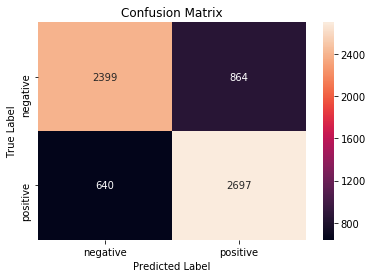

In [36]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.79      0.74      0.76      3263
   positive       0.76      0.81      0.78      3337

avg / total       0.77      0.77      0.77      6600



# Observations

look at the bow observations for clarifying doubt.
In tfidf when the value of k = 49 which is quite high, accuracy is also good.
In a nutshell we can say this model works well with unseen data.

## word2vec

In [38]:
# data
X = final_20k["Text"]
X.shape

(20000,)

In [39]:
# Target/class-label
y = final_20k["Score"]
y.shape

(20000,)

In [40]:

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape, x_test.shape)

(8978,) (8978,) (6600,)


In [41]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [42]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\chavha1\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [43]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [44]:
w2v_model.wv.most_similar('like')

[('enjoy', 0.6748203635215759),
 ('weird', 0.6643911600112915),
 ('overpower', 0.6480542421340942),
 ('notice', 0.6464089751243591),
 ('plain', 0.6416813731193542),
 ('think', 0.6339290738105774),
 ('burnt', 0.631700873374939),
 ('smell', 0.6299490332603455),
 ('awful', 0.6271390914916992),
 ('prefer', 0.6236495971679688)]

In [45]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\chavha1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [46]:
w2v.shape

(6055, 50)

In [47]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [48]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [49]:
w2v_model.wv.most_similar('like')

[('prefer', 0.7194319367408752),
 ('enjoy', 0.7139710187911987),
 ('smell', 0.7074031233787537),
 ('buds', 0.6808453798294067),
 ('artificial', 0.6617031097412109),
 ('overwhelm', 0.6596153378486633),
 ('think', 0.6562767624855042),
 ('chocolate', 0.6543957591056824),
 ('murky', 0.6492905616760254),
 ('love', 0.6486421823501587)]

In [50]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\chavha1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [51]:
w2v.shape

(5200, 50)

## Average Word2Vec

In [52]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

8978
50


In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

6600
50


In [55]:
X_train = sent_vectors

In [59]:
x_test = sent_vectors_test


The optimal number of neighbors is 49.


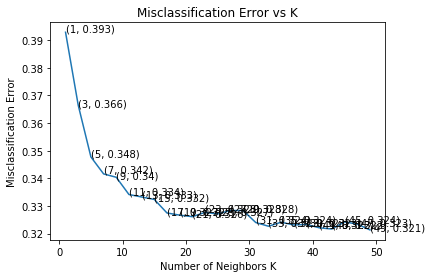

the misclassification error for each k value is :  [0.393 0.366 0.348 0.342 0.34  0.334 0.333 0.332 0.327 0.327 0.326 0.328
 0.327 0.328 0.328 0.324 0.323 0.324 0.323 0.323 0.322 0.322 0.324 0.323
 0.321]


49

In [60]:
optimal_k_avgw2v = k_classifier_brute(X_train, y_train)
optimal_k_avgw2v

In [61]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [62]:
# Accuracy on train data
train_acc_avgw2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_avgw2v)

Train accuracy 0.6990421029182446


In [63]:
# Error on train data
train_err_avgw2v = 1-train_acc_avgw2v
print("Train Error %f%%" % (train_err_avgw2v))

Train Error 0.300958%


In [64]:
# evaluate accuracy
acc_avg_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgw2v, acc_avg_w2v))


The accuracy of the knn classifier for k = 49 is 68.803030%


In [65]:
print("Test Error %f%%" %-(100-(acc_avg_w2v)))

Test Error -31.196970%


In [66]:
cm = confusion_matrix(y_test, pred)
cm

array([[2462,  794],
       [1265, 2079]], dtype=int64)

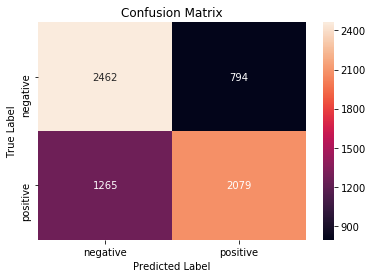

In [67]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.66      0.76      0.71      3256
   positive       0.72      0.62      0.67      3344

avg / total       0.69      0.69      0.69      6600



# Tf-Idf weighted Word2Vec

In [84]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape, x_test.shape)

(8978,) (8978,) (6600,)


In [85]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

C:\Users\chavha1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [86]:
len(tfidf_sent_vectors)

8978

In [87]:
X_train = tfidf_sent_vectors

In [88]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

C:\Users\chavha1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [89]:
len(tfidf_sent_vectors_test)

6600

In [90]:
x_test = tfidf_sent_vectors_test

In [91]:
X_train = np.nan_to_num(X_train)

In [92]:
x_test = np.nan_to_num(x_test)


The optimal number of neighbors is 7.


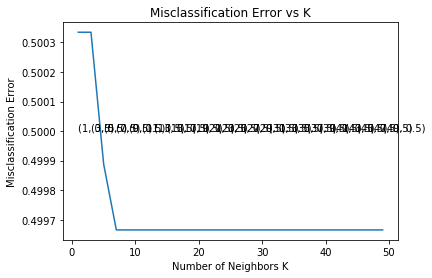

the misclassification error for each k value is :  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


7

In [93]:
optimal_k_tfidf_w2v = k_classifier_brute(X_train, y_train)
optimal_k_tfidf_w2v

In [95]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_w2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [96]:
# Accuracy on train data
train_acc_tfidf_w2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf_w2v)

Train accuracy 0.5003341501447984


In [97]:
# Error on train data
train_err_tfidf_w2v = 1-train_acc_tfidf_w2v
print("Train Error %f%%" % (train_err_tfidf_w2v))

Train Error 0.499666%


In [98]:
# evaluate accuracy
acc_tfidf_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf_w2v, acc_tfidf_w2v))


The accuracy of the knn classifier for k = 7 is 50.348485%


In [99]:
print("Test Error %f%%" %-(100-(acc_tfidf_w2v)))

Test Error -49.651515%


In [100]:
cm = confusion_matrix(y_test, pred)
cm

array([[3323,    0],
       [3277,    0]], dtype=int64)

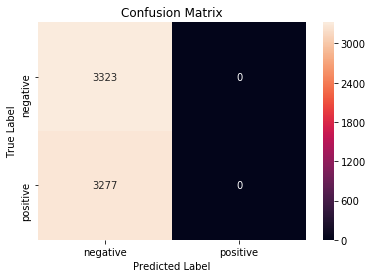

In [101]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.50      1.00      0.67      3323
   positive       0.00      0.00      0.00      3277

avg / total       0.25      0.50      0.34      6600



C:\Users\chavha1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Observations

The tfidf_w2v model is looks like dumb model because it is biased towards majority class, as the total # of actual +ve class was 3023(true positive) and classifier predicted all points as +ve class.
## Conclusions

As in "knn with tfidf" when k = 49 the accuracy is quite good than other models. In this model, train_error and test_error is low.
As we know when a model performs good on training data but poor performence on unseen data(test data)i.e. its dependent on training data only, tends towards overfits and when a model perform poor performence on training data and good performence on test data i.e. it fails to learn relationship in training data tends towards underfit. We need to balance between both i.e. reduce training error and reduce error between training and testing error.
Another concept bias vs variance is also related with underfitting and overfitting. when a model has high bias and low variance tend towards underfitting and its reverse- high variance and low bias called overfitting and we balanced using cross-validataion. As it is shown in below table where first three models have low trainig error and test error. But the accuracy it low which we can boost using some techniques.
There are lot more things to write here but for now that's all. Will look more in next excercise.

In [103]:
# model
models = pd.DataFrame({'Model': ['KNN with Bow', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"], 'Hyper Parameter(K)': [optimal_k_bow, optimal_k_tfidf, optimal_k_avgw2v, optimal_k_tfidf_w2v], 'Train Error': [train_err_bow, train_err_tfidf, train_err_avgw2v, train_err_tfidf_w2v], 'Test Error': [100-acc_bow, 100-acc_tfidf, 100-acc_avg_w2v, 100-acc_tfidf_w2v], 'Accuracy': [acc_bow, acc_tfidf, acc_avg_w2v, acc_tfidf_w2v]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
1,KNN with TFIDF,49,0.197706,22.787879,77.212121
2,KNN with Avg_w2v,49,0.300958,31.196970,68.803030
0,KNN with Bow,23,0.302963,34.000000,66.000000
3,KNN with tfidf_w2v,7,0.499666,49.651515,50.348485
